In [2]:
import os
import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore') #safety is no one priority

from dask import bag
from dask.diagnostics import ProgressBar
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
df=pd.read_csv("data.csv")
label=df["outcome_categorical"]
df=df.drop("outcome_categorical",axis=1)

In [4]:
df.head()

,1,2,3,4,5,outcome_cont,7,8,9,10,...,69,70,71,72,73,74,75,76,77,78
0,0,0,410,0,0.0,1307.76,2,3,0,1,...,0,0,0,1,0,0,14.0,43.592000,14.0,category one
1,0,0,205,205,0.0,4827.18,0,1,0,1,...,0,0,0,1,0,0,10.0,26.817667,10.0,category one
2,0,0,0,0,0.0,10378.52,2,2,0,2,...,0,0,0,0,0,1,10.0,49.403111,10.0,category two
3,0,0,50,100,0.0,11863.83,2,2,0,1,...,0,0,0,1,0,0,10.0,65.910167,10.0,category one
4,0,0,102,102,0.0,165.00,2,1,0,1,...,0,0,0,0,0,0,10.0,0.916667,10.0,category one


In [5]:
def catch_collinear_variables(dataframe,threshold):
    matrix=dataframe.corr()
    extracted_matrix=matrix.where(np.triu(np.ones(matrix.shape),k=1).astype(bool))
    collinear_variables=[]
    for i in extracted_matrix.columns:
        if any(abs(extracted_matrix[i])>threshold):
            pair_variables=extracted_matrix.index[extracted_matrix.loc[:,i]>threshold].tolist()
            for _ in pair_variables:
                collinear_variables.append((i,_))
    return collinear_variables



    

In [6]:
#will remove that variable in the tuple which is less important on the basis of some modeling technique preferably xgb or gbm
res=catch_collinear_variables(df,0.95)
res

[('66', '65'), ('77', '75')]

In [7]:
# categorizing variables
remove_=[i for i in df.columns if df[i].nunique()==1]
cats_=list(set(list(df.columns))-set(list(df._get_numeric_data().columns)))
bools_=[i for i in df.columns if df[i].nunique()==2 and i not in cats_] 
ords_=[i for i in df.columns if df[i].nunique()<=5 and df[i].nunique()>2 and i not in cats_]
nums_=[i for i in df.columns if df[i].nunique()>5 and i not in cats_]


In [8]:
#removing variable with no variance
df=df.drop(remove_,axis=1)

#converting bools to bool datatype
for _ in bools_:
    df[_]=df[_].astype('bool')

#converting ordinals to integer datatype
for _ in ords_:
    df[_]=df[_].astype('int')
    
#converting nums to float datatype
for _ in nums_:
    df[_]=df[_].astype('float')

    


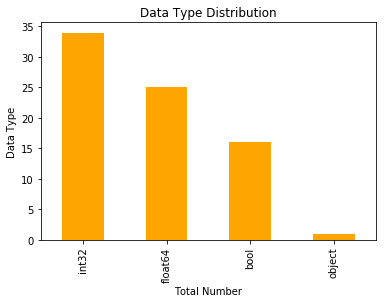

In [11]:
%matplotlib inline
df.dtypes.value_counts().plot(kind='bar',color = 'orange')
plt.title('Data Type Distribution')
plt.xlabel('Total Number')
plt.ylabel('Data Type')
plt.show()

<b>An EntitySet in Featuretools holds all of the tables and the relationships between them. At the moment we only have a single table, but we can create multiple entry in entityset as well.</b>

In [12]:
es=ft.EntitySet(id="engineering")


In [17]:
#Adding entity to the entityset
es.entity_from_dataframe(entity_id="dataset",dataframe=df,make_index=True,already_sorted=False,index="id")

Entityset: engineering
  Entities:
    dataset [Rows: 16580, Columns: 77]
  Relationships:
    No relationships

In [14]:
df

,1,2,3,4,5,outcome_cont,7,8,9,10,...,69,70,71,72,73,74,75,76,77,78
0,0,0,410.0,0.0,0.00,1307.76,2.0,3.0,0,1,...,False,False,0,1,0,0,14.000000,43.592000,14.00,category one
1,0,0,205.0,205.0,0.00,4827.18,0.0,1.0,0,1,...,False,False,0,1,0,0,10.000000,26.817667,10.00,category one
2,0,0,0.0,0.0,0.00,10378.52,2.0,2.0,0,2,...,False,False,0,0,0,1,10.000000,49.403111,10.00,category two
3,0,0,50.0,100.0,0.00,11863.83,2.0,2.0,0,1,...,False,False,0,1,0,0,10.000000,65.910167,10.00,category one
4,0,0,102.0,102.0,0.00,165.00,2.0,1.0,0,1,...,False,False,0,0,0,0,10.000000,0.916667,10.00,category one
5,0,0,0.0,0.0,0.00,8453.48,1.0,3.0,0,1,...,False,False,0,1,0,0,10.000000,46.963778,10.00,category one
6,0,0,0.0,214.0,1481.03,4252.97,2.0,3.0,0,2,...,False,False,0,1,0,1,10.000000,37.186786,10.00,category two
7,0,0,0.0,0.0,3.00,7983.43,1.0,1.0,0,1,...,False,False,0,1,0,0,10.000000,44.352389,10.00,category one
8,0,0,0.0,47.0,0.00,13.98,2.0,5.0,0,1,...,False,False,0,1,0,0,10.000000,0.077667,10.00,category one
9,0,1,0.0,3050.0,0.00,15.00,4.0,15.0,0,1,...,False,False,0,1,0,0,10.000000,0.107914,10.00,category one
